In [2]:
import io
from PIL import Image
import torch
import torchvision.transforms as transforms 
import torch.nn as nn
import timm
from torchvision.transforms import ToTensor
from torchvision.transforms import v2
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
stats = ((0.5087, 0.5006, 0.4405),(0.2128, 0.2084, 0.2120))
with open('animalnames.txt') as f:
    class_names = [x.strip('\n') for x in f.readlines()]

Using device: cpu


In [3]:
model = timm.create_model('resnet50',
                          pretrained=True,
                          num_classes = 90).to(device)
MODEL_SAVE_PATH = '../pytorch saved model/AnimalImageClassificationResnet50.pth'
loaded_model = model
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH ,map_location=torch.device('cpu')))
loaded_model = loaded_model.to(device)

In [4]:
loaded_model.eval()

def transform_image(image_bytes : bytearray, means:tuple[float] , stds :tuple[float]):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(size=(224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize(mean = means , std =stds,inplace = True),
        ])

    image = Image.open(io.BytesIO(image_bytes))
    return transform(image)

def denormalize(image_tensor :torch.Tensor, means : tuple[float], stds: tuple[float]):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return image_tensor * stds + means

def get_prediction(image_tensor : torch.Tensor):
    images = image_tensor.unsqueeze(0)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    return class_names[predicted]

In [5]:
import matplotlib.pyplot as plt
def plot_predicted_image(image_path : str, means :tuple[float] , stds:tuple[float] ,prediction = None )->None:
    files={'file': open(f'{image_path}', 'rb')}
    file = files['file']
    image_byte = file.read()
    image_tensor = transform_image(image_byte , means=means , stds=stds)
    denormalized_image = denormalize(image_tensor,means = means , stds = stds).squeeze(0)
    if  prediction != None:
        plt.figure(figsize = (8,8))
        plt.title(f'Model Predicted : {get_prediction(image_tensor=image_tensor)}')
        plt.imshow(denormalized_image.permute(1,2,0).clamp(0,1))
        plt.axis(False)
    else:
        plt.figure(figsize = (8,8))
        plt.title(f'{denormalized_image.shape}')
        plt.imshow(denormalized_image.permute(1,2,0).clamp(0,1))
        plt.axis(False)

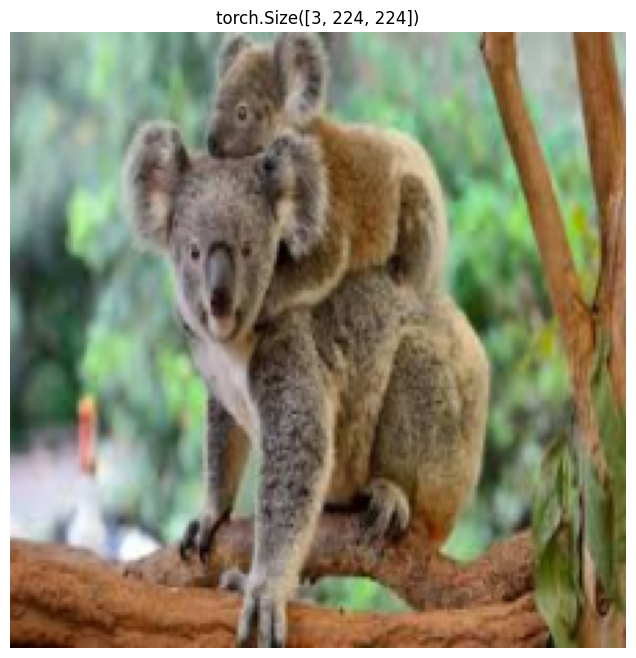

In [8]:
plot_predicted_image(image_path='images/test5.jpeg', means = stats[0] , stds = stats[1] ,prediction=None)